In [18]:
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, BasicAer

from qiskit.tools.visualization import plot_histogram

In [19]:
n = 16
qr = QuantumRegister(n, name='qr')
cr = ClassicalRegister(n, name='cr')

In [20]:
alice = QuantumCircuit(qr, cr, name='Alice')

alice_key = np.random.randint(0, high=2**n)

alice_key = np.binary_repr(alice_key, n) 

In [21]:
for index, digit in enumerate(alice_key):
    if digit == '1':
        alice.x(qr[index]) 
        
alice_table = []        
for index in range(len(qr)):       
    if 0.5 < np.random.random():   
        alice.h(qr[index])         
        alice_table.append('X')    
    else:
        alice_table.append('Z')    

In [22]:





def SendState(qc1, qc2, qc1_name):
    ''' This function takes the output of a circuit qc1 (made up only of x and 
        h gates and initializes another circuit qc2 with the same state
    ''' 
    
    
    qs = qc1.qasm().split(sep=';')[4:-1]

    
    for index, instruction in enumerate(qs):
        qs[index] = instruction.lstrip()

    
    for instruction in qs:
        if instruction[0] == 'x':
            old_qr = int(instruction[5:-1])
            qc2.x(qr[old_qr])
        elif instruction[0] == 'h':
            old_qr = int(instruction[5:-1])
            qc2.h(qr[old_qr])
        elif instruction[0] == 'm': 
            pass
        else:
            raise Exception('Unable to parse instruction')

In [23]:
bob = QuantumCircuit(qr, cr, name='Bob')

SendState(alice, bob, 'Alice')    


bob_table = []
for index in range(len(qr)): 
    if 0.5 < np.random.random():  
        bob.h(qr[index])        
        bob_table.append('X')
    else:
        bob_table.append('Z')

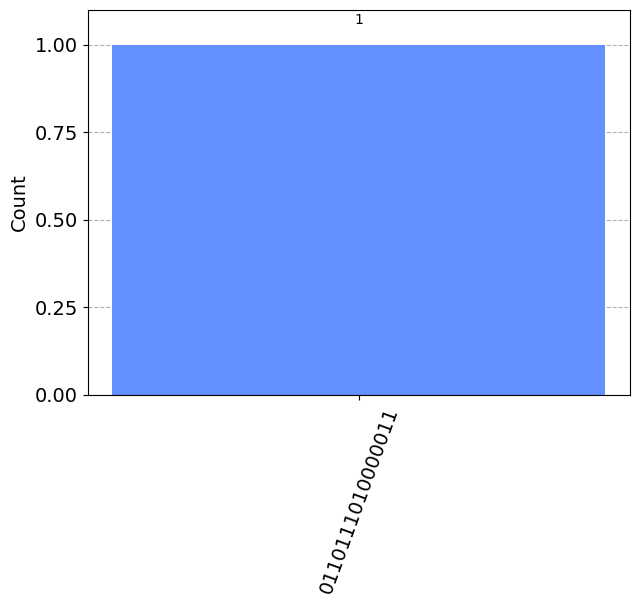

In [24]:

for index in range(len(qr)): 
    bob.measure(qr[index], cr[index])
    

backend = BasicAer.get_backend('qasm_simulator')    
result = execute(bob, backend=backend, shots=1).result()
plot_histogram(result.get_counts(bob))

In [25]:

bob_key = list(result.get_counts(bob))[0]
bob_key = bob_key[::-1]

In [26]:
keep = []
discard = []
for qubit, basis in enumerate(zip(alice_table, bob_table)):
    if basis[0] == basis[1]:
        print("Same choice for qubit: {}, basis: {}" .format(qubit, basis[0])) 
        keep.append(qubit)
    else:
        print("Different choice for qubit: {}, Alice has {}, Bob has {}" .format(qubit, basis[0], basis[1]))
        discard.append(qubit)

Different choice for qubit: 0, Alice has Z, Bob has X
Different choice for qubit: 1, Alice has X, Bob has Z
Same choice for qubit: 2, basis: X
Different choice for qubit: 3, Alice has X, Bob has Z
Different choice for qubit: 4, Alice has Z, Bob has X
Same choice for qubit: 5, basis: X
Different choice for qubit: 6, Alice has X, Bob has Z
Same choice for qubit: 7, basis: Z
Same choice for qubit: 8, basis: X
Same choice for qubit: 9, basis: X
Different choice for qubit: 10, Alice has Z, Bob has X
Same choice for qubit: 11, basis: Z
Same choice for qubit: 12, basis: X
Different choice for qubit: 13, Alice has Z, Bob has X
Same choice for qubit: 14, basis: Z
Same choice for qubit: 15, basis: Z


In [27]:
acc = 0
for bit in zip(alice_key, bob_key):
    if bit[0] == bit[1]:
        acc += 1

print('Percentage of qubits to be discarded according to table comparison: ', len(keep)/n)
print('Measurement convergence by additional chance: ', acc/n)                

Percentage of qubits to be discarded according to table comparison:  0.5625
Measurement convergence by additional chance:  0.875


In [28]:
new_alice_key = [alice_key[qubit] for qubit in keep]
new_bob_key = [bob_key[qubit] for qubit in keep]

acc = 0
for bit in zip(new_alice_key, new_bob_key):
    if bit[0] == bit[1]:
        acc += 1        
        
print('Percentage of similarity between the keys: ', acc/len(new_alice_key))             

Percentage of similarity between the keys:  1.0


In [29]:
if (acc//len(new_alice_key) == 1):
    print("Key exchange has been successfull")
    print("New Alice's key: ", new_alice_key)
    print("New Bob's key: ", new_bob_key)
else:
    print("Key exchange has been tampered! Check for eavesdropper or try again")
    print("New Alice's key is invalid: ", new_alice_key)
    print("New Bob's key is invalid: ", new_bob_key)

Key exchange has been successfull
New Alice's key:  ['0', '0', '1', '0', '1', '1', '0', '1', '0']
New Bob's key:  ['0', '0', '1', '0', '1', '1', '0', '1', '0']


In [30]:
eve = QuantumCircuit(qr, cr, name='Eve')
SendState(alice, eve, 'Alice')   

In [31]:
eve_table = []
for index in range(len(qr)): 
    if 0.5 < np.random.random(): 
        eve.h(qr[index])        
        eve_table.append('X')
    else:
        eve_table.append('Z')

In [32]:
for index in range(len(qr)): 
    eve.measure(qr[index], cr[index])
    

backend = BasicAer.get_backend('qasm_simulator')    
result = execute(eve, backend=backend, shots=1).result()


eve_key = list(result.get_counts(eve))[0]
eve_key = eve_key[::-1]

In [33]:

for qubit, basis in enumerate(zip(alice_table, eve_table)):
    if basis[0] == basis[1]:
        print("Same choice for qubit: {}, basis: {}" .format(qubit, basis[0]))
    else:
        print("Different choice for qubit: {}, Alice has {}, Eve has {}" .format(qubit, basis[0], basis[1]))
        if eve_key[qubit] == alice_key[qubit]:
            eve.h(qr[qubit])
        else:
            if basis[0] == 'X' and basis[1] == 'Z':
                eve.h(qr[qubit])
                eve.x(qr[qubit])
            else:
                eve.x(qr[qubit])
                eve.h(qr[qubit])

Same choice for qubit: 0, basis: Z
Same choice for qubit: 1, basis: X
Same choice for qubit: 2, basis: X
Same choice for qubit: 3, basis: X
Same choice for qubit: 4, basis: Z
Same choice for qubit: 5, basis: X
Different choice for qubit: 6, Alice has X, Eve has Z
Different choice for qubit: 7, Alice has Z, Eve has X
Same choice for qubit: 8, basis: X
Different choice for qubit: 9, Alice has X, Eve has Z
Same choice for qubit: 10, basis: Z
Different choice for qubit: 11, Alice has Z, Eve has X
Different choice for qubit: 12, Alice has X, Eve has Z
Same choice for qubit: 13, basis: Z
Same choice for qubit: 14, basis: Z
Same choice for qubit: 15, basis: Z


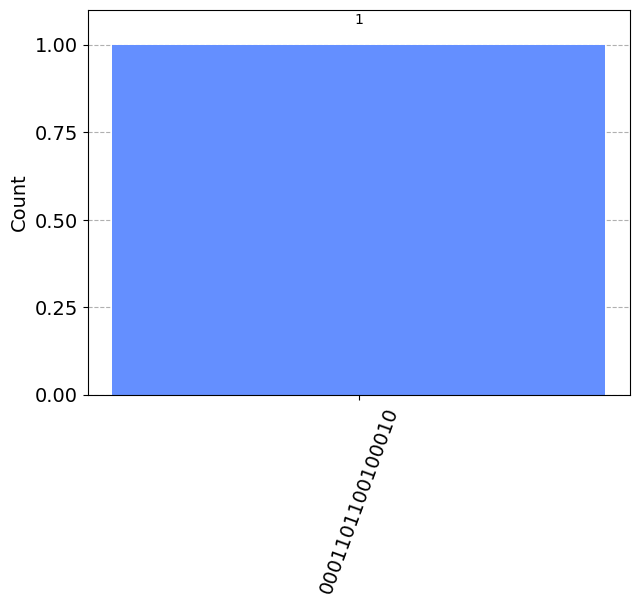

In [34]:
SendState(eve, bob, 'Eve')
          
bob_table = []
for index in range(len(qr)): 
    if 0.5 < np.random.random(): 
        bob.h(qr[index])      
        bob_table.append('X')
    else:
        bob_table.append('Z')
          
for index in range(len(qr)): 
    bob.measure(qr[index], cr[index])
          
result = execute(bob, backend=backend, shots=1).result()
plot_histogram(result.get_counts(bob))